/Users/uge/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


***TIMEIT get_all_data TOOK: 1.143 s
       count  mean  std  min  25%  50%  75%  max
ldr  2725278   251  234   11   33  162  478  748


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10cb8db38>]], dtype=object)

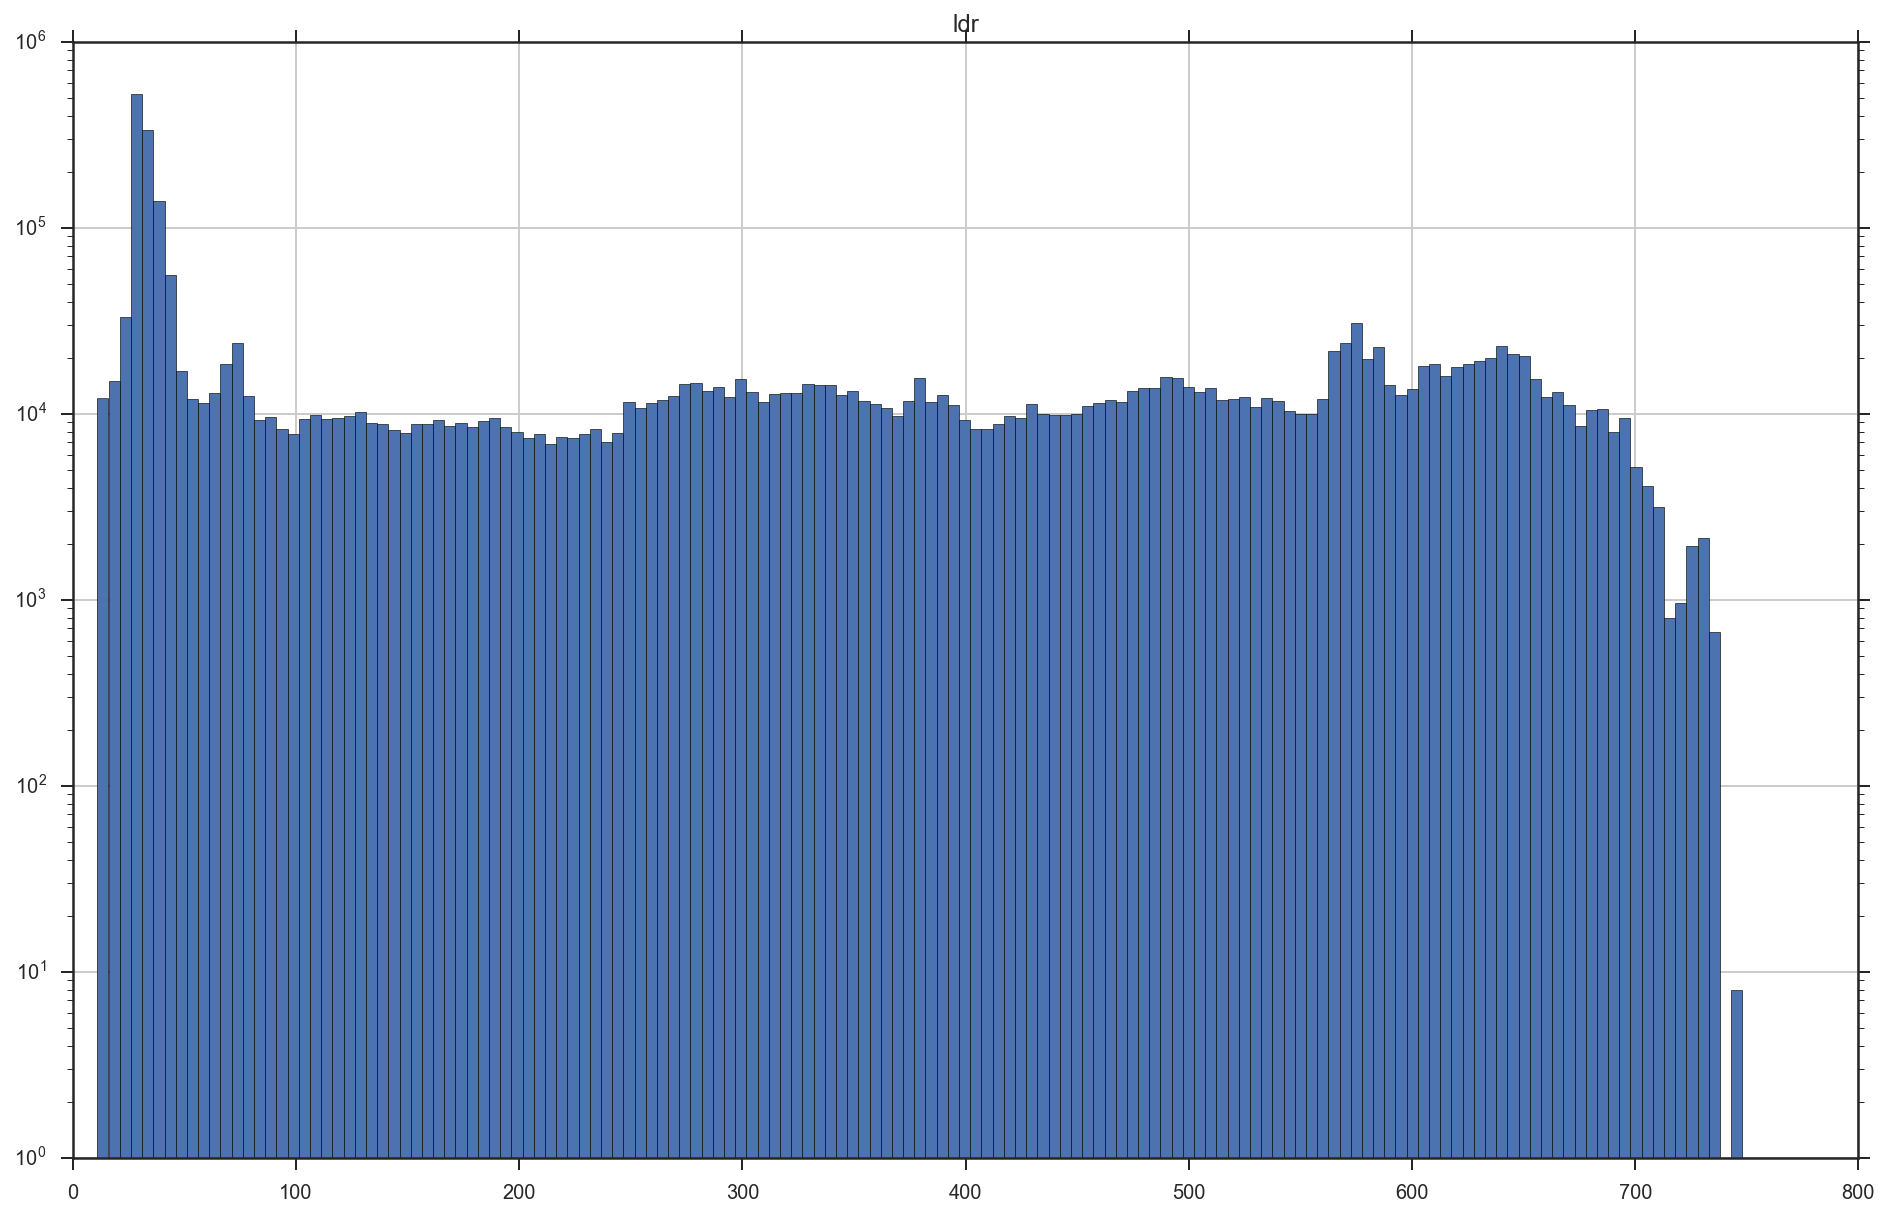

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import Image, HTML

import datetime as dt
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mpd
import numexpr as ne
import numpy as np
import pandas as pd
import pytz
import random
import scipy
from scipy import signal
from scipy.signal import medfilt
import seaborn as sns

from enerpi.base import timeit
from enerpi.api import enerpi_data_catalog
from enerpi.enerplot import write_fig_to_svg, tableau20
from enerpi.sunposition import sun_position
from prettyprinting import *


LAT = 38.631463
LONG = -0.866402
ELEV_M = 500
TZ = pytz.timezone('Europe/Madrid')
FS = (16, 10)


def _tslim(ax, h0=12, hf=22, m0=0, mf=0):
    xlim = [mpd.num2date(x, tz=TZ) for x in ax.get_xlim()]
    new = [mpd.date2num(d.replace(hour=h, minute=m)) for d, h, m in zip(xlim, [h0, hf], [m0, mf])]
    ax.set_xlim(new)
    return ax


sns.set_style('ticks')

# Catálogo y lectura de todos los datos.
cat = enerpi_data_catalog()
data, data_s = cat.get_all_data()
LDR = pd.DataFrame(data.ldr).tz_localize(TZ)

print_cyan(LDR.describe().T.astype(int))
LDR.hist(bins=(LDR.max() - LDR.min() + 1).values[0] // 5, log=True, figsize=FS)

In [2]:
@timeit('gen_data_ldr_minutes', verbose=True)
def gen_data_ldr_minutes(LDR):
    homog = LDR.resample('1s').mean().fillna(method='ffill', limit=5).fillna(method='bfill', limit=5).fillna(-1)

    ldr_minutos = homog.resample('1min').ldr.apply(lambda x: pd.Series([np.median(x), np.min(x), np.max(x)], 
                                                                       index=['ldr_median', 'ldr_min', 'ldr_max'])
                                                  ).astype('int32').unstack()
    ldr_minutos['time'] = ldr_minutos.index.time
    ldr_minutos['minute_day'] = ldr_minutos.index.hour * 60 + ldr_minutos.index.minute
    ldr_minutos = ldr_minutos.join(sun_position(ldr_minutos.index, latitude_deg=LAT, longitude_deg=LONG, elevation=ELEV_M).round(1))
    minutos_no_nulos_mask = ldr_minutos.ldr_min > 0

    ldr_usar = ldr_minutos[minutos_no_nulos_mask]
    print_red('{} --> {} válidos. Head:\n{}'.format(len(ldr_minutos), len(ldr_usar), ldr_usar.head()))
    return ldr_usar


ldr_usar = gen_data_ldr_minutes(LDR)
ldr_usar.info()

47674 --> 45739 válidos. Head:
                           ldr_median  ldr_min  ldr_max      time  minute_day  \
ts                                                                              
2016-08-12 10:46:00+02:00         656      656      661  10:46:00         646   
2016-08-12 10:48:00+02:00         656      655      657  10:48:00         648   
2016-08-12 10:49:00+02:00         654      652      656  10:49:00         649   
2016-08-12 10:50:00+02:00         653      651      655  10:50:00         650   
2016-08-12 10:51:00+02:00         656      653      657  10:51:00         651   

                           altitude  azimuth  
ts                                            
2016-08-12 10:46:00+02:00      39.7    -76.2  
2016-08-12 10:48:00+02:00      40.1    -75.8  
2016-08-12 10:49:00+02:00      40.3    -75.6  
2016-08-12 10:50:00+02:00      40.5    -75.4  
2016-08-12 10:51:00+02:00      40.7    -75.2  
gen_data_ldr_minutes TOOK: 21.718 s
<class 'pandas.core.frame.DataFrame'

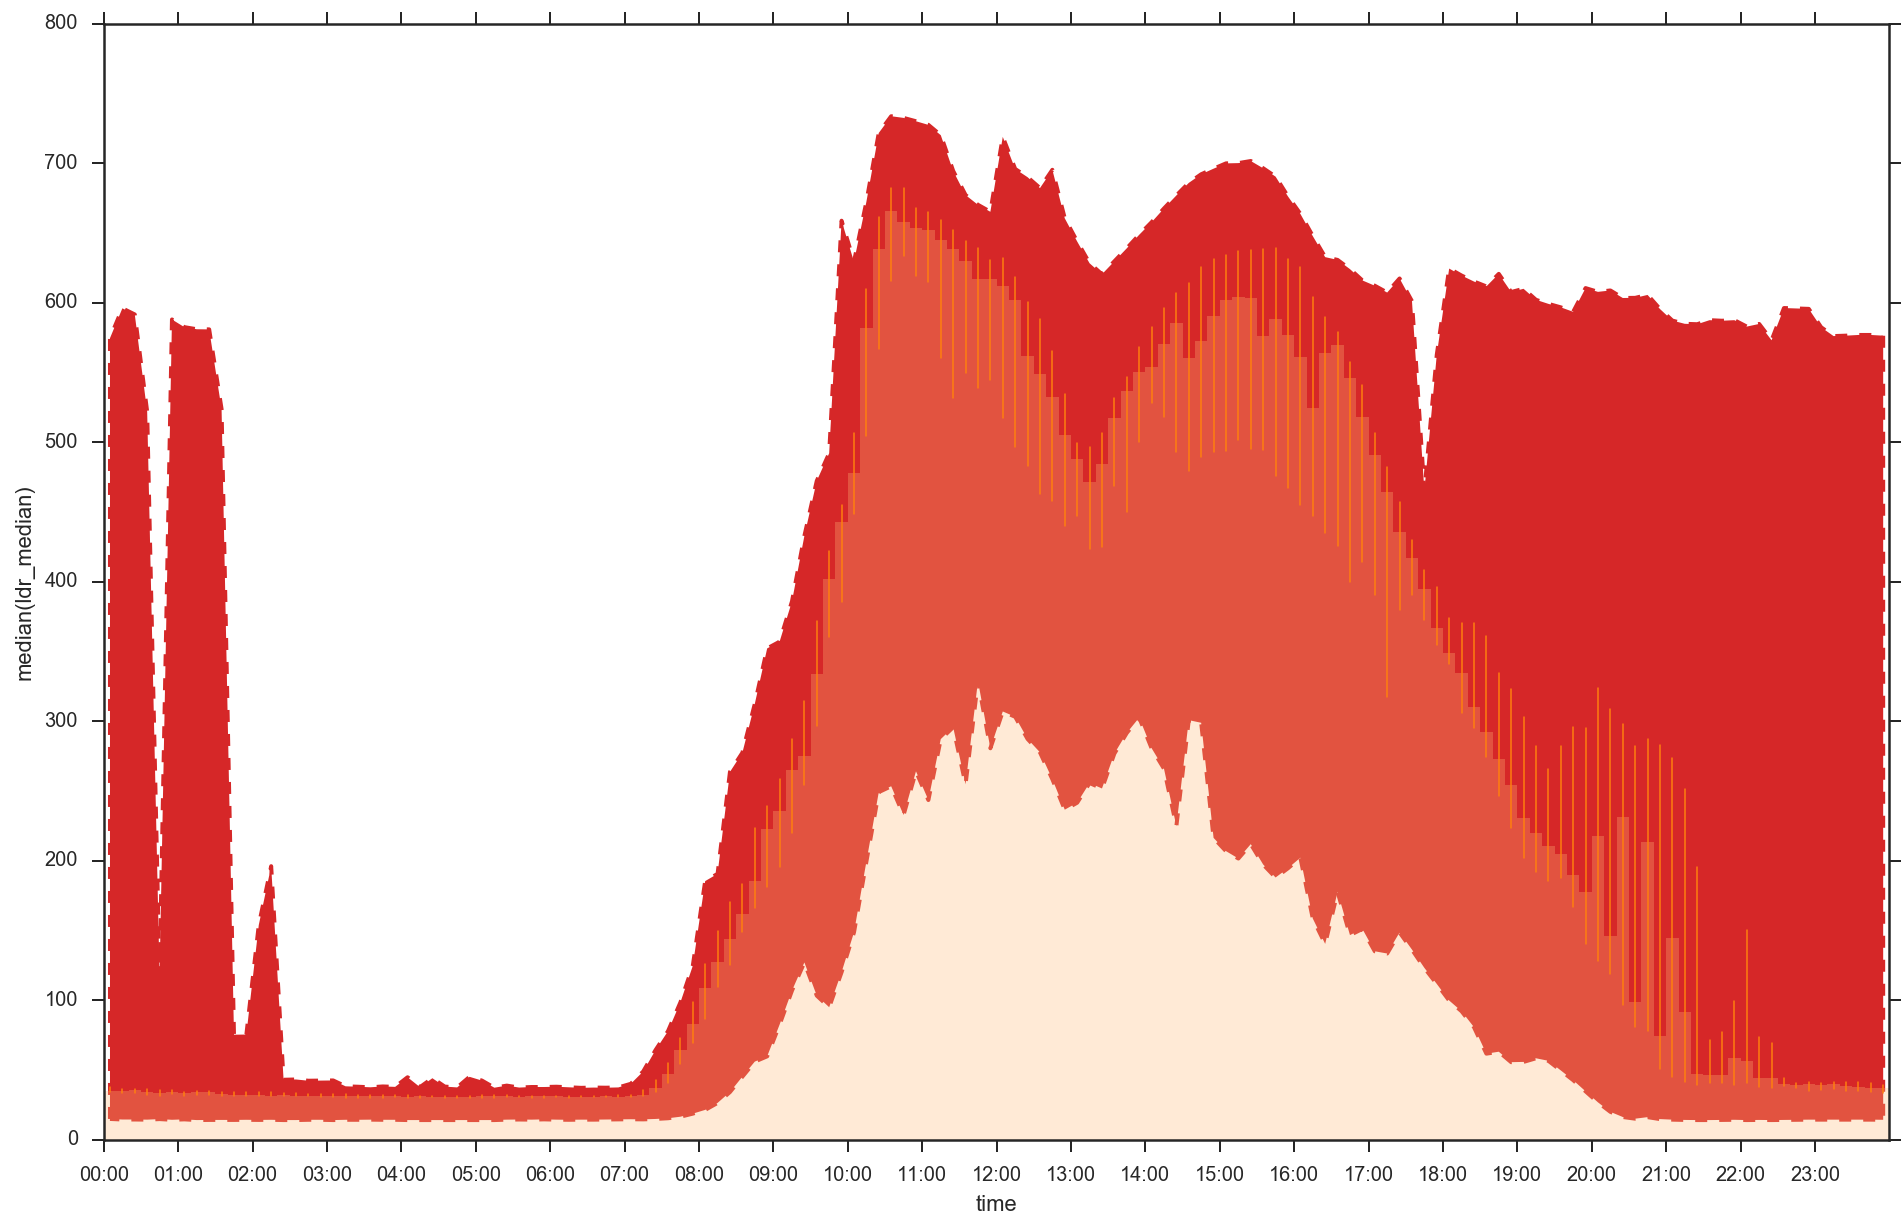

In [5]:
def plot_barplot_typical_day_ldr(ldr_plot, delta_rs='10min', step_labels=6):
    ldr_10m = ldr_plot.resample(delta_rs).mean()
    ldr_10m['time'] = ldr_10m.index.time

    fig = plt.figure(figsize=FS)
    ax = sns.barplot(x='time', y='ldr_median', data=ldr_10m.sort_values(by='time'), ci=90, estimator=np.median, 
                     errcolor=tableau20[2], linewidth=0, facecolor=list(tableau20[3]) + [.3], capsize=1)
    for bar in ax.patches:
        x = bar.get_x()
        width = bar.get_width()
        centre = x + width / 2.
        bar.set_x(centre - 1 / 2.)
        bar.set_width(1.)
    for line in ax.lines:
        line.set_linewidth(.75)

    x_t = ax.get_xticks()
    x_tl = ax.get_xticklabels()
    ax.set_xticks(x_t[::step_labels] - .5)
    ax.set_xticklabels([t.get_text()[:-3] for t in x_tl[::step_labels]]);

    cota_max = ldr_10m.groupby('time').ldr_min.min().reset_index(drop=True)
    cota_min = ldr_10m.groupby('time').ldr_max.max().reset_index(drop=True)
    ax.fill_between(cota_max.index, cota_min, cota_max, color=tableau20[6], facecolor=list(tableau20[7]) + [.2], linestyle='--', lw=2)
    #ldr_10m.groupby('time').ldr_min.min().reset_index(drop=True).plot(ax=ax, color=tableau20[2], ls='--', lw=2.5)
    #ldr_10m.groupby('time').ldr_max.max().reset_index(drop=True).plot(ax=ax, color=tableau20[4], ls='--', lw=2.5)
    return ax


ax = plot_barplot_typical_day_ldr(ldr_usar);

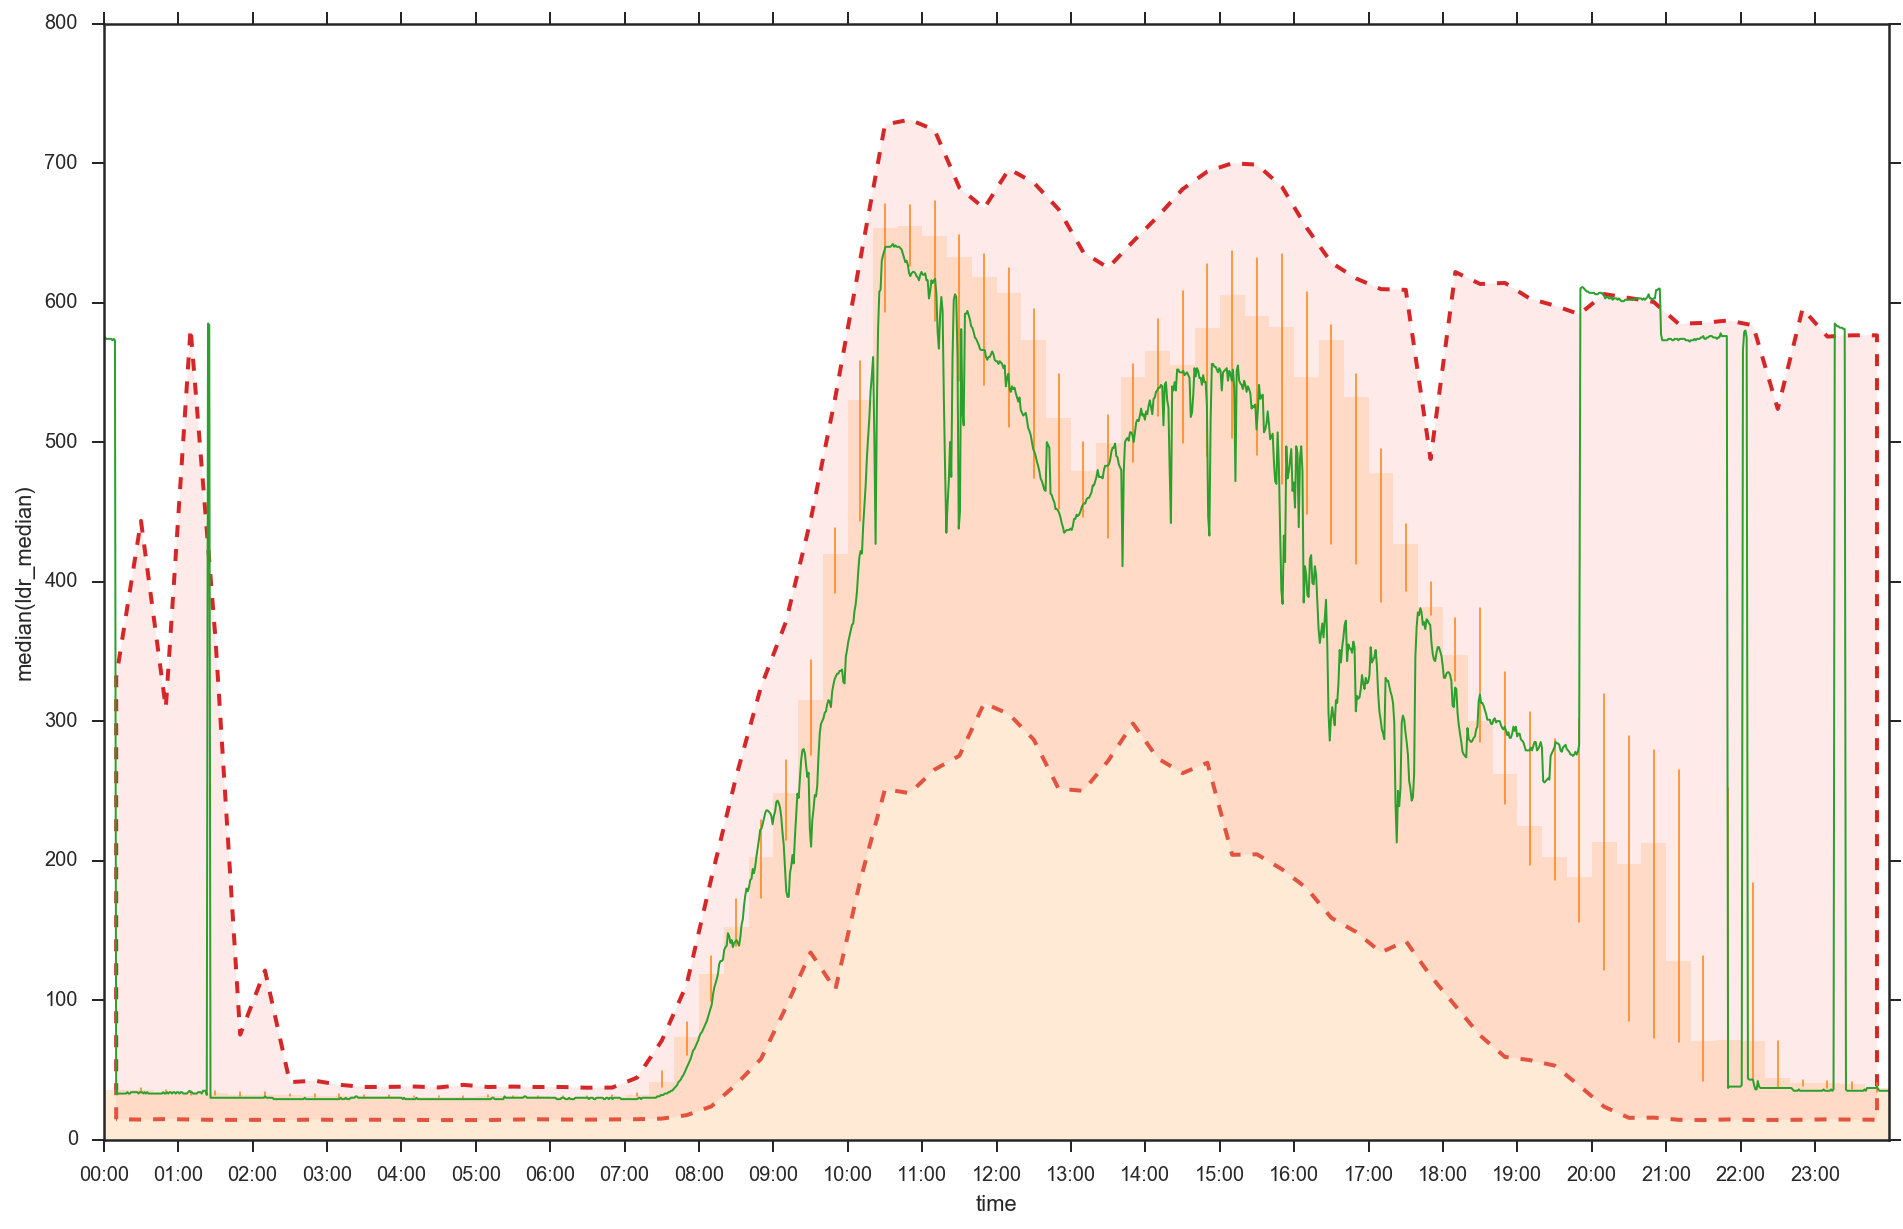

In [119]:
ax = plot_barplot_typical_day_ldr(ldr_usar, delta_rs='20min', step_labels=3);

xlim = ax.get_xlim()
day_raw = ldr_usar.loc['2016-09-13'].reset_index()
day_raw.index = np.linspace(*xlim, len(day_raw))
day_raw.ldr_median.plot(ax=ax, color=tableau20[4], lw=1)

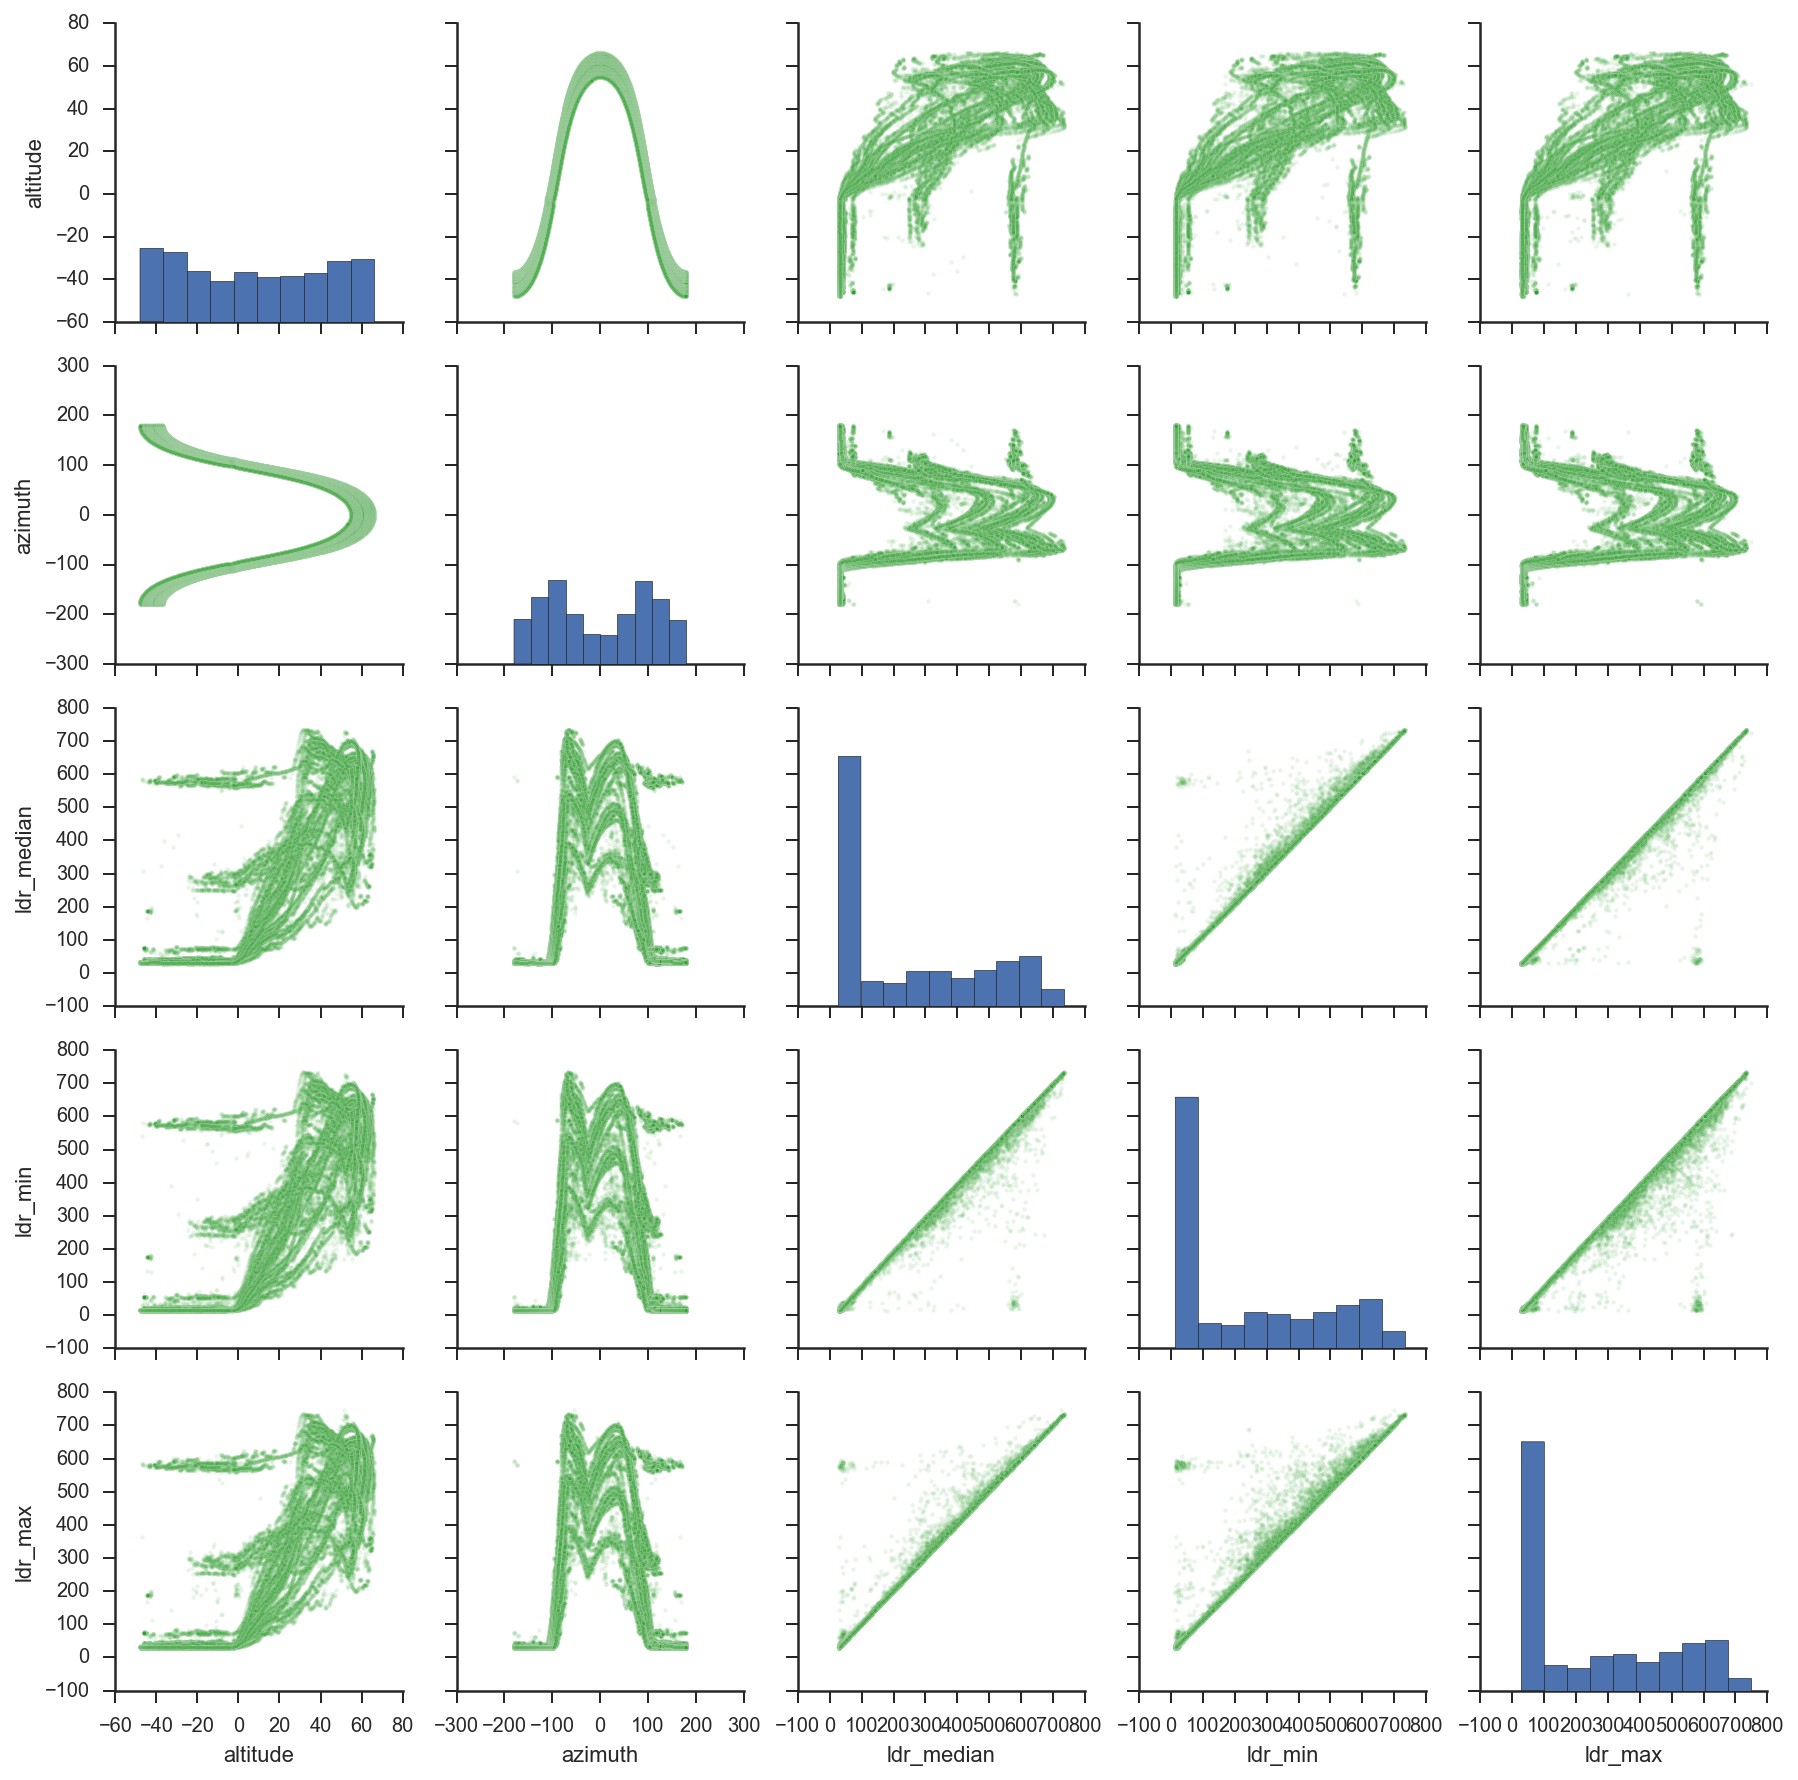

In [138]:
#day_raw = ldr_usar.loc['2016-09-13'].reset_index()

sns.set(style="ticks", color_codes=True)
sns.pairplot(ldr_usar[['altitude', 'azimuth', 'ldr_median', 'ldr_min', 'ldr_max']], #kind="reg", 
             #y_vars=['altitude', 'azimuth', 'ldr_median'], x_vars=['ldr_median', 'ldr_min', 'ldr_max'],
             plot_kws=dict(s=5, facecolor=tableau20[4], lw=0, alpha=.1))

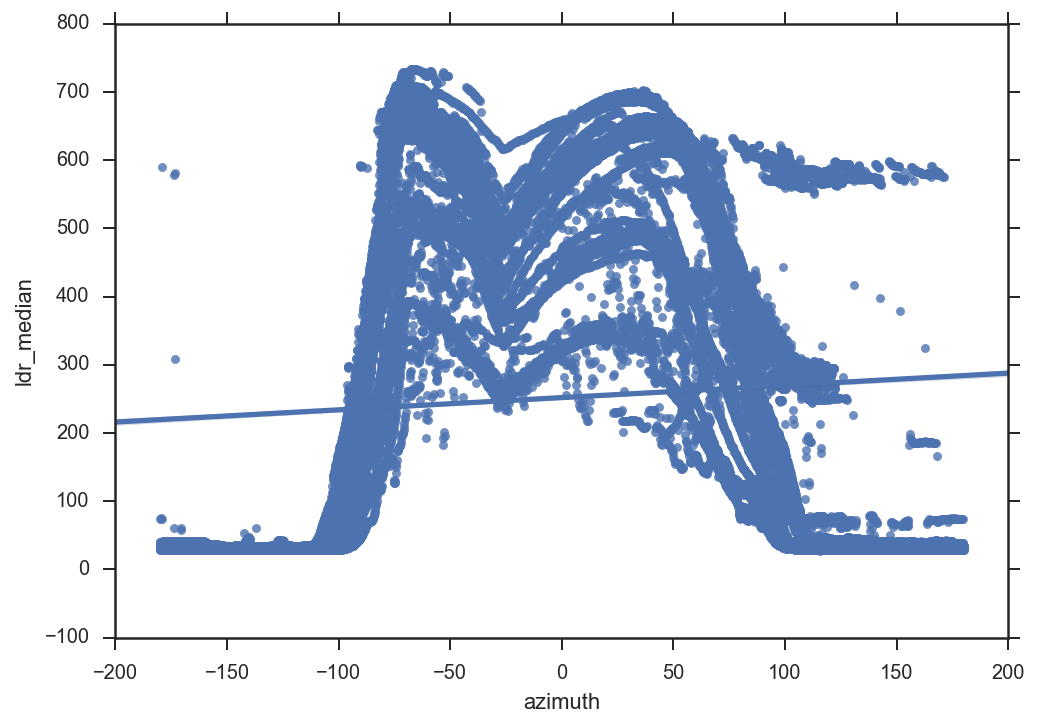

In [176]:
sns.regplot(data=ldr_usar, x='azimuth', y='ldr_median')

Index(['ldr_median', 'ldr_min', 'ldr_max', 'time', 'minute_day', 'altitude',
       'azimuth'],
      dtype='object')


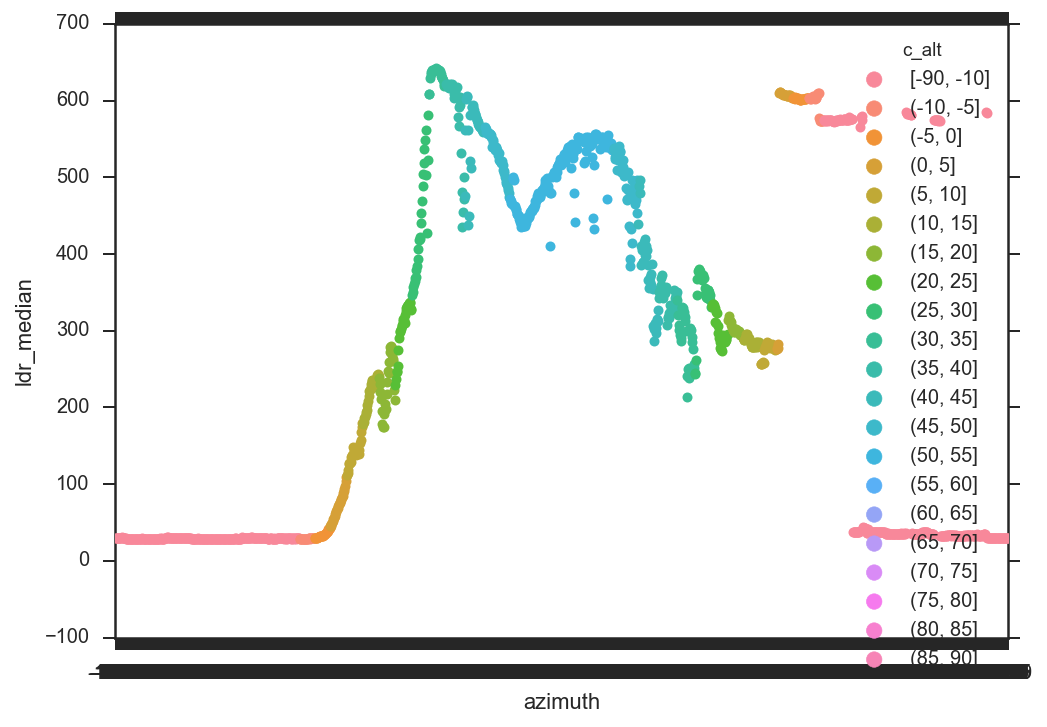

In [177]:
print(ldr_usar.columns)
day_raw['c_alt'] = pd.cut(day_raw.altitude.values, [-90] + list(np.linspace(-10, 90, 21)), include_lowest=True)

sns.swarmplot(x='azimuth', y='ldr_median', data=day_raw, hue='c_alt')

In [6]:
#sns.swarmplot(x='azimuth', y='ldr_median', data=day_raw, hue='c_alt')
#day_raw.plot(kind='scatter', x='azimuth', y='ldr_median', color='c_alt')
#arr = np.concatenate(np.array([-90]), np.linspace(-10, 90, 20))
#arr
#sns.regplot
#margins = [0, 0, 1, 1, 0.05, 0.05]
#gs = plt.GridSpec(5, 2, *margins)
#fig = plt.figure(figsize=FS)
#shape_grid = (9, 9)
#plt.subplot2grid(shape_grid, (0, 0), 6, 6)
#plt.subplot2grid(shape_grid, (0, 6), 3, 3)
#plt.subplot2grid(shape_grid, (3, 6), 3, 3)
#plt.subplot2grid(shape_grid, (6, 6), 3, 3)
#plt.subplot2grid(shape_grid, (6, 0), 3, 6)
#fig.tight_layout()

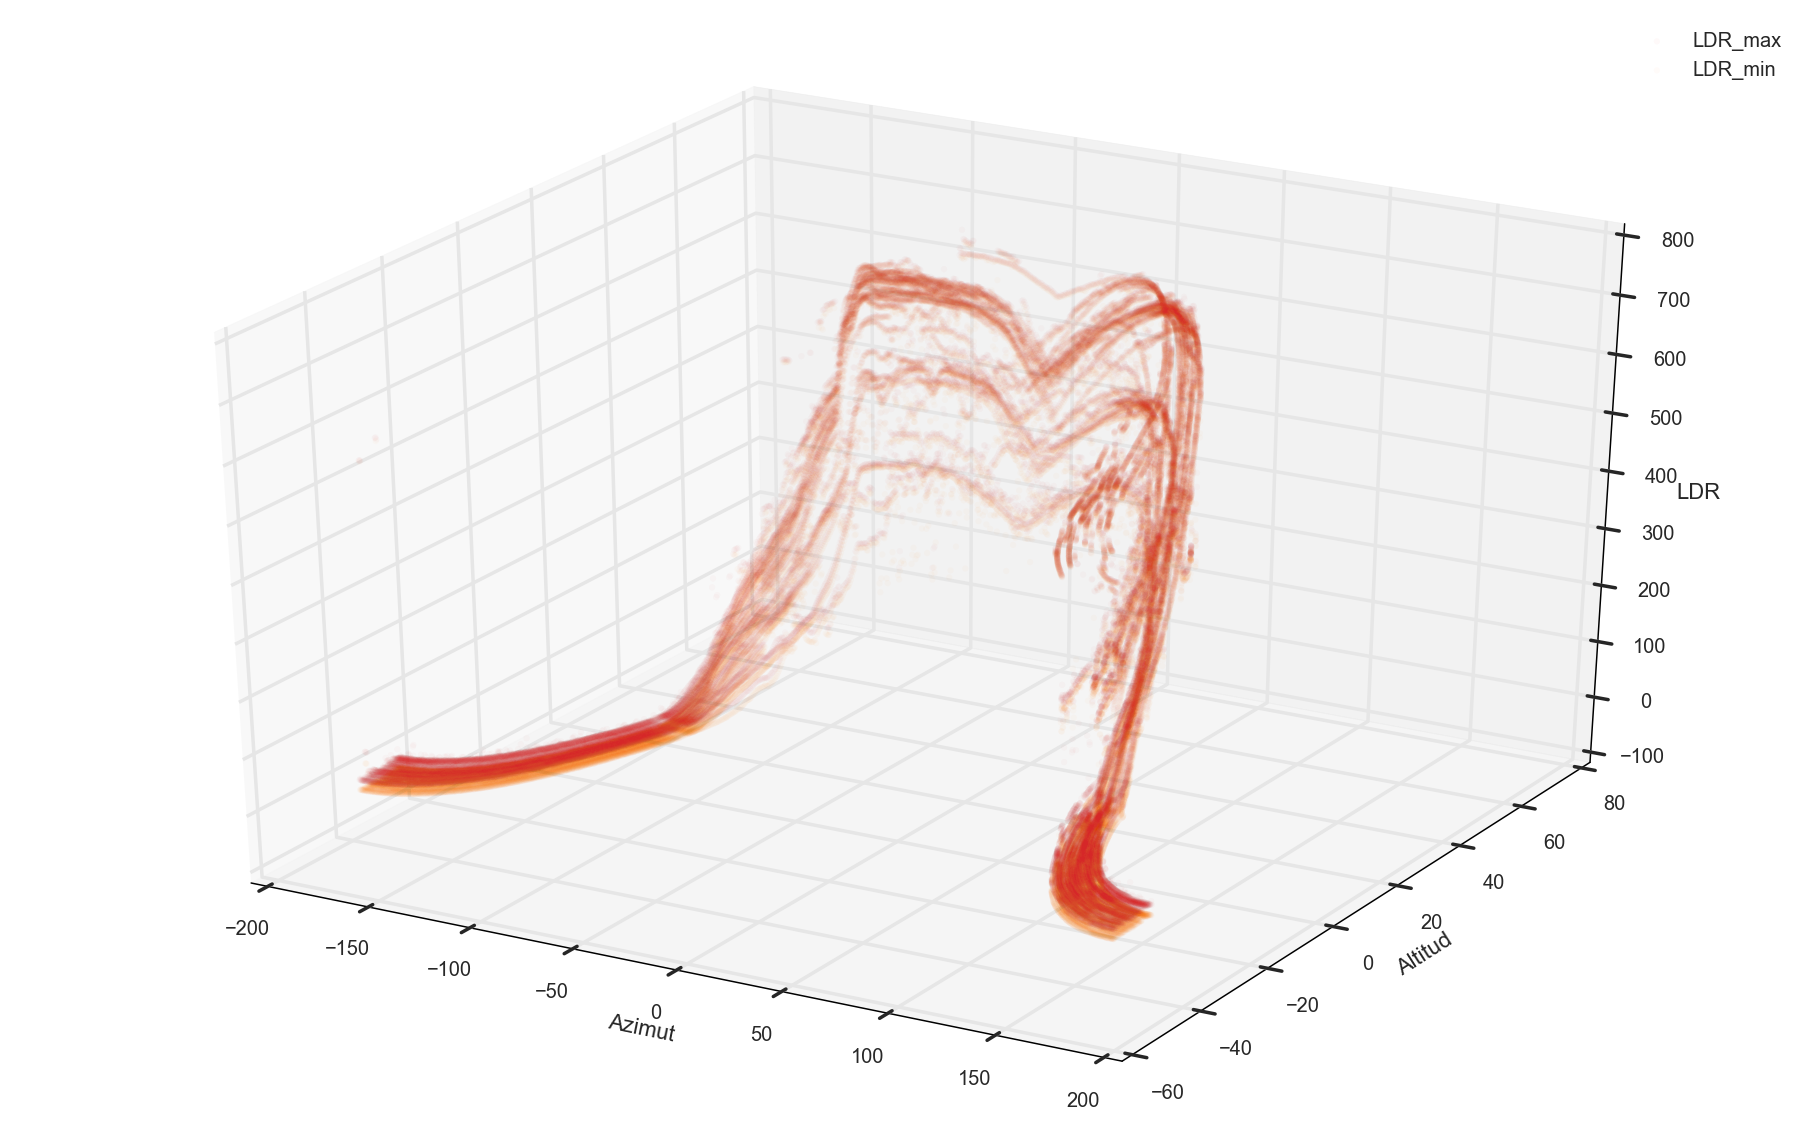

In [209]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=FS)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ldr_usar.azimuth, ldr_usar.altitude, ldr_usar.ldr_max, c=tableau20[6], marker='o', alpha=.025, lw=0, s=10, label='LDR_max')
# ax.scatter(ldr_usar.azimuth, ldr_usar.altitude, ldr_usar.ldr_median, c=tableau20[4], marker='o', alpha=.05, lw=0, s=10, label='LDR_median')
ax.scatter(ldr_usar.azimuth, ldr_usar.altitude, ldr_usar.ldr_min, c=tableau20[2], marker='o', alpha=.025, lw=0, s=10, label='LDR_min')
ax.set_xlabel('Azimut')
ax.set_ylabel('Altitud')
ax.set_zlabel('LDR')
plt.legend()
plt.show()

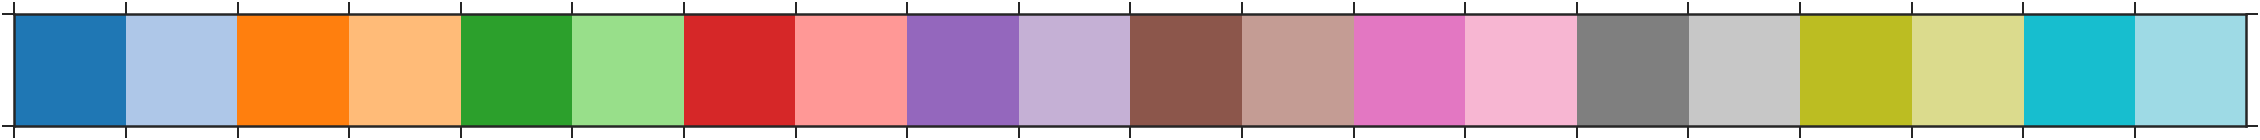

In [7]:
sns.palplot(tableau20)

In [8]:
def _extract_features_events(eventos_feat, data_ldr_mf_steps, features_around=10):
    # Feature as raw as waveform around event:
    # eventos_feat = eventos_tot[eventos_tot.es_subida]
    X_ag = np.zeros((len(eventos_feat), 4 * features_around + eventos_feat.shape[1]))
    for i, (t, row) in enumerate(eventos_feat.iterrows()):
        iloc = data_ldr_mf_steps.index.get_loc(t)
        xi_1 = data_ldr_mf_steps.iloc[iloc - features_around:iloc + features_around].values[:, 1]
        xi_2 = data_ldr_mf_steps.iloc[iloc - features_around:iloc + features_around].values[:, 2]
        xi_3 = row.sort_index().values
        X_ag[i, :] = np.concatenate([xi_3, xi_1, xi_2])
    return X_ag



In [10]:
homog = LDR.resample('1s').mean().fillna(method='ffill', limit=5).fillna(method='bfill', limit=5).fillna(-1)
df_filter = homog.iloc[:100000].copy()
df_filter['median_filter'] = medfilt(df_filter.ldr, kernel_size=11)
print_red(df_filter.shape)
df_filter.head(10)

(100000, 2)


,ldr,median_filter
ts,,
2016-08-12 10:46:25+02:00,661.0,657.0
2016-08-12 10:46:26+02:00,661.0,657.0
2016-08-12 10:46:27+02:00,660.0,657.0
2016-08-12 10:46:28+02:00,659.0,657.0
2016-08-12 10:46:29+02:00,658.0,657.0
2016-08-12 10:46:30+02:00,657.0,657.0
2016-08-12 10:46:31+02:00,657.0,657.0
2016-08-12 10:46:32+02:00,657.0,657.0
2016-08-12 10:46:33+02:00,657.0,657.0


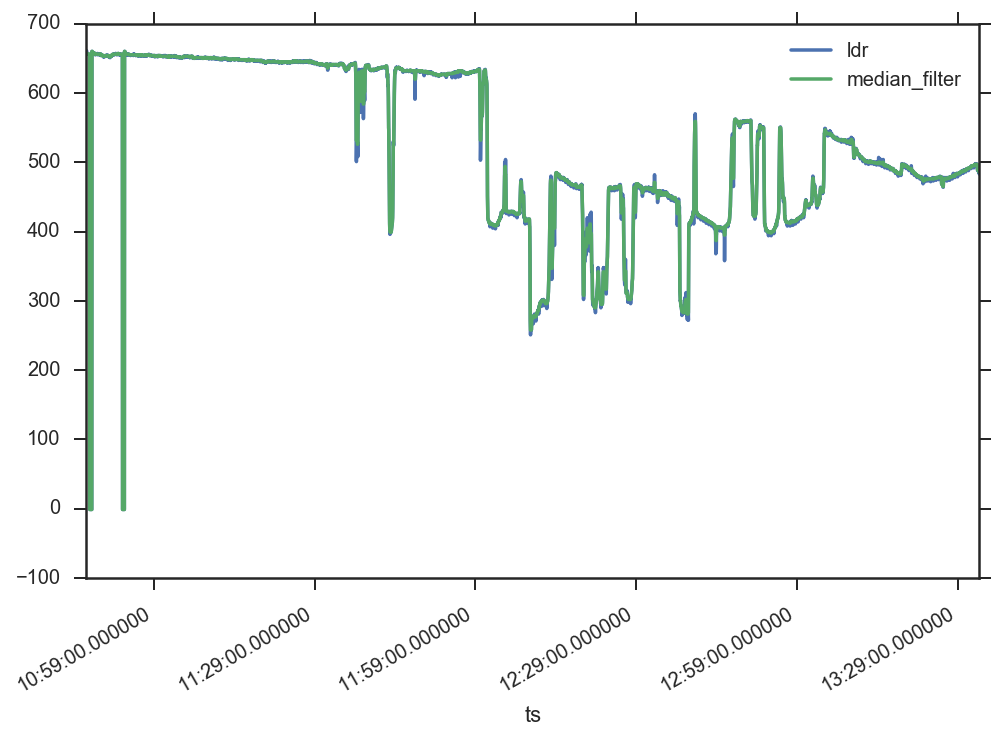

In [245]:
df_filter.iloc[:10000].plot()

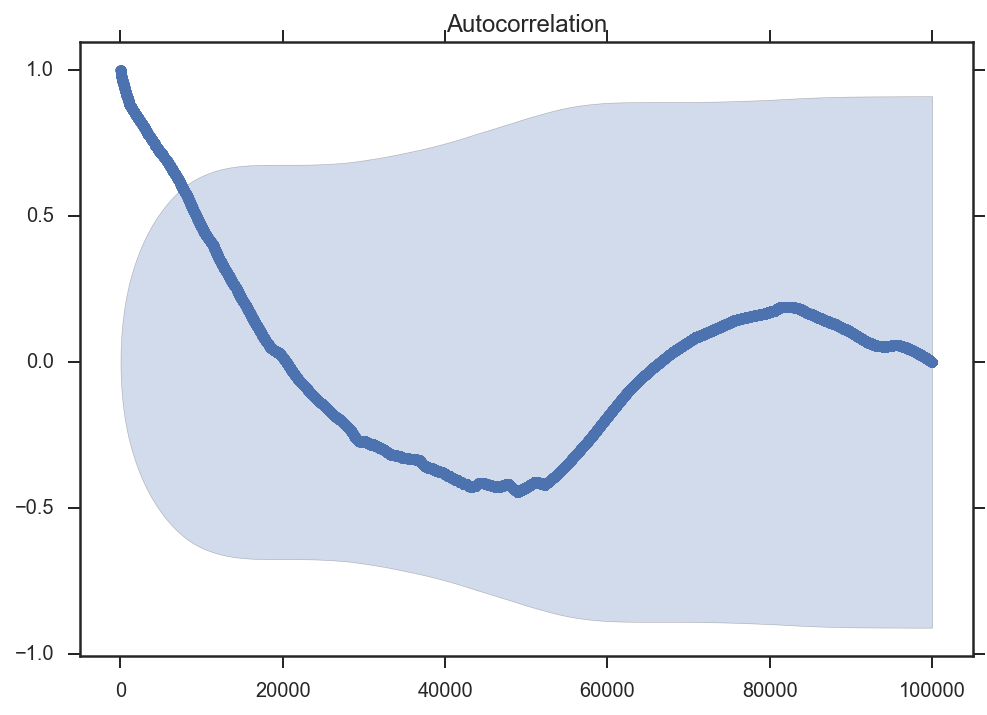

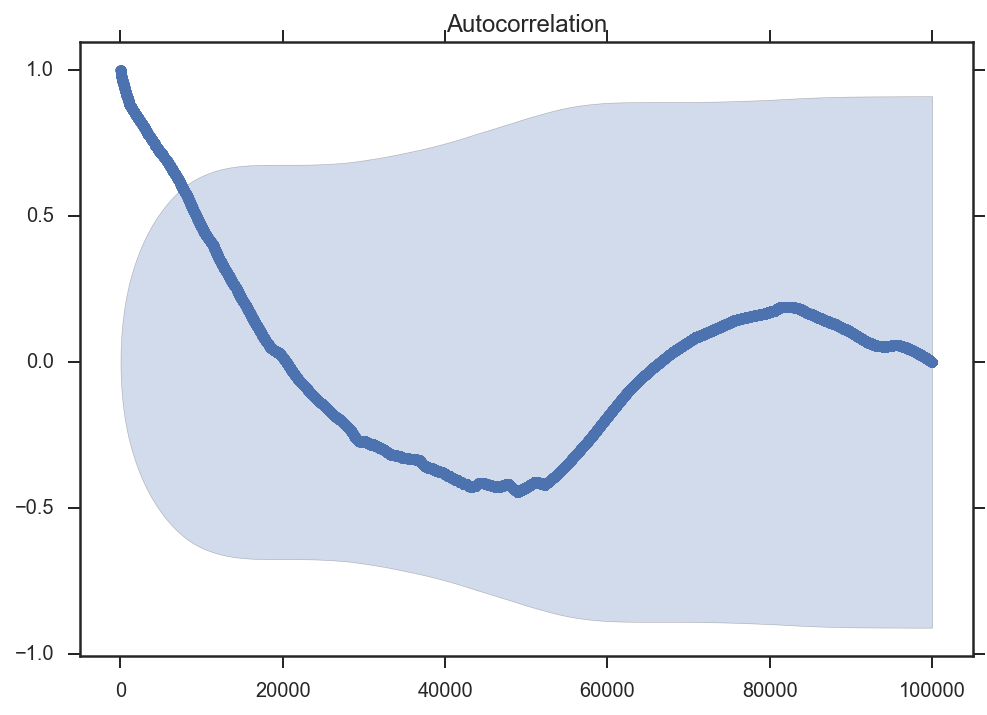

In [56]:
import statsmodels.api as sm

#ldr_minutos
sm.graphics.tsa.plot_acf(pruebas, use_vlines=False, unbiased=False)
#(dta.values.squeeze(), lags=40, ax=ax1)

In [ ]:
sm.graphics.tsa.plot_pacf(ldr_minutos.iloc[:10000].ldr_median, use_vlines=False)

In [80]:
pruebas = LDR.iloc[:100000].ldr.astype(float)
arma = sm.tsa.ARMA(pruebas, (7, 0)).fit()
arma

In [81]:
print(arma.aic, arma.bic, arma.hqic)
print(arma.params)
print_magenta(sm.stats.durbin_watson(arma.resid.values))

508154.8591240313 508240.475453 508180.84159
const        292.104615
ar.L1.ldr      1.644141
ar.L2.ldr     -0.972972
ar.L3.ldr      0.624163
ar.L4.ldr     -0.505329
ar.L5.ldr      0.312270
ar.L6.ldr     -0.152607
ar.L7.ldr      0.050189
dtype: float64
1.87135638143


In [33]:
#arma.geterrors()
#sm.tsa.ARMA?
sm.tsa.periodogram(pruebas)

array([        0.        ,  38352292.05760474,   2196606.29679549, ...,
         2794353.96090697,   2196606.29679548,  38352292.05760474])

In [ ]:
#sm.tsa.seasonal_decompose(pruebas)

1.8569322779722865

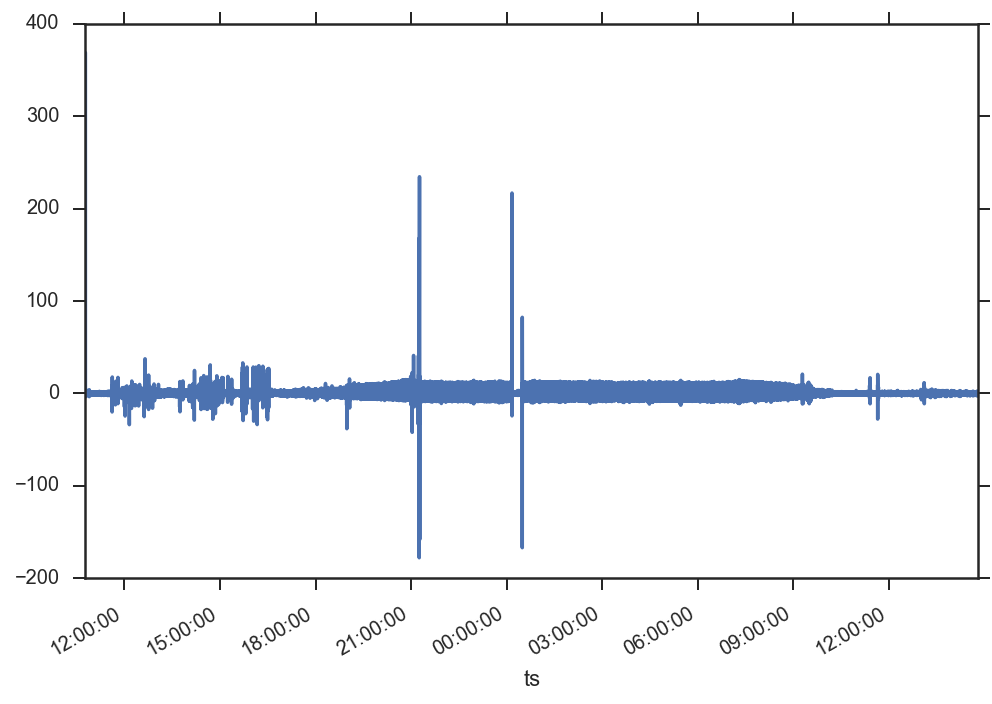

In [60]:
arma.resid.plot()

In [75]:

r_nt = scipy.stats.normaltest(arma.resid, nan_policy='omit')
r_nt

NormaltestResult(statistic=211989.44483449106, pvalue=0.0)

In [76]:
#stats.quadratic_mean?
scipy.stats.normaltest(pruebas, nan_policy='omit')

NormaltestResult(statistic=256.40023159140566, pvalue=2.1057030712528242e-56)

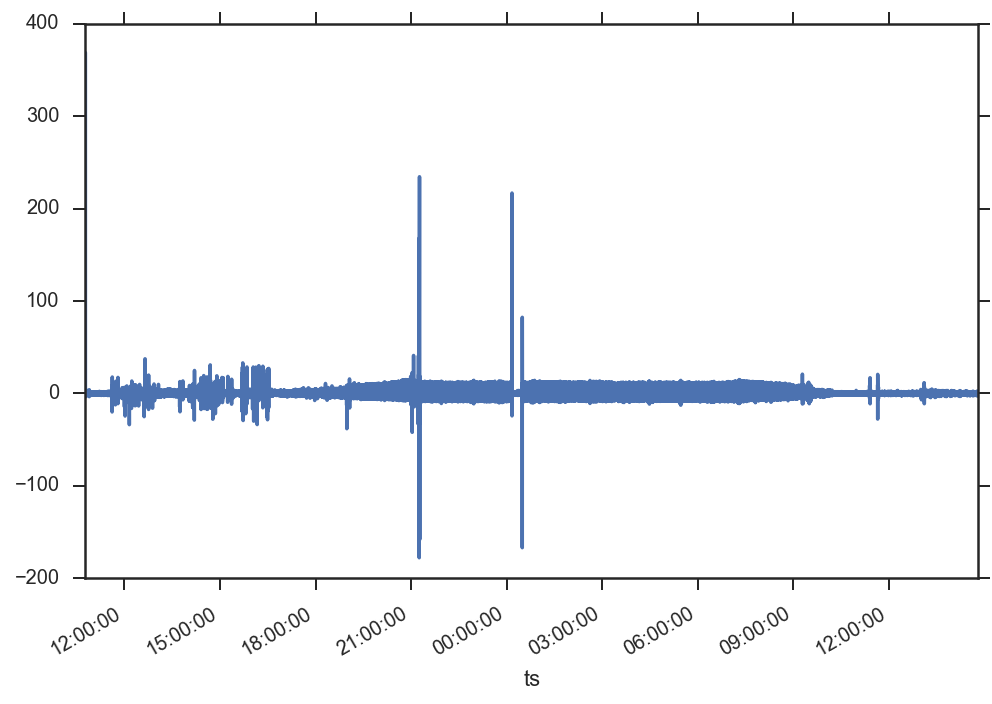

In [78]:
arma.resid.plot()